In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
diabetes = pd.read_csv('data/diabetes_data.csv')
display(diabetes.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Gender
0,6,98,58,33,190,34.0,0.430,43,0,Female
1,2,112,75,32,0,35.7,0.148,21,0,Female
2,2,108,64,0,0,30.8,0.158,21,0,Female
3,8,107,80,0,0,24.6,0.856,34,0,Female
4,7,136,90,0,0,29.9,0.210,50,0,Female


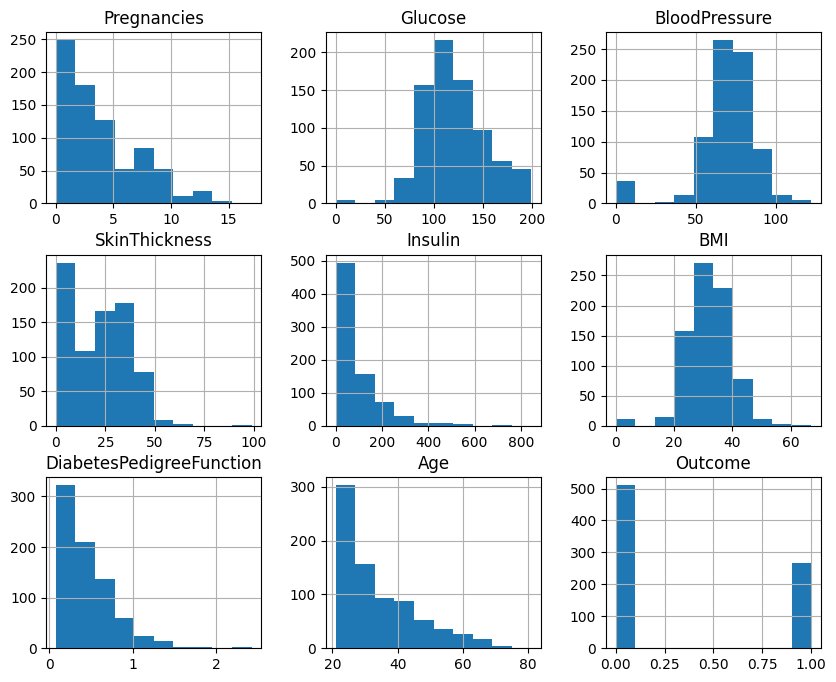

In [2]:
diabetes.hist(figsize=(10,8));

#### Задание 8.1
Начнём с поиска дубликатов в данных. Найдите все повторяющиеся строки в данных и удалите их. Для поиска используйте все признаки в данных. Сколько записей осталось в данных?

In [27]:
#mask = diabetes.duplicated()
#dupl_diabetes = diabetes[mask]
diabetes = diabetes.drop_duplicates()
display(diabetes.shape[0])


768

#### Задание 8.2
Далее найдите все неинформативные признаки в данных и избавьтесь от них. В качестве порога информативности возьмите 0.95: удалите все признаки, для которых 95 % значений повторяются или 95 % записей уникальны. В ответ запишите имена признаков, которые вы нашли (без кавычек).

In [4]:

not_information_cols = []
for col in diabetes.columns:
    top_freq = diabetes[col].value_counts(normalize=True).max()
    nunique_ratio = diabetes[col].nunique() / diabetes[col].count()
    if top_freq > 0.95 or nunique_ratio > 0.95:
        not_information_cols.append(col)
        
display(not_information_cols)

['Gender']

In [5]:
diabetes = diabetes.drop(not_information_cols, axis=1)

#### Задание 8.3
Попробуйте найти пропуски в данных с помощью метода isnull().

Спойлер: ничего не найдёте. А они есть! Просто они скрыты от наших глаз. В таблице пропуски в столбцах Glucose, BloodPressure, SkinThickness, Insulin и BMI обозначены нулём, поэтому традиционные методы поиска пропусков ничего вам не покажут. Давайте это исправим!

Замените все записи, равные 0, в столбцах Glucose, BloodPressure, SkinThickness, Insulin и BMI на символ пропуска. Его вы можете взять из библиотеки numpy: np.nan.

Какая доля пропусков содержится в столбце Insulin? Ответ округлите до сотых.

In [6]:
diabetes_copy = diabetes.copy()
#display(diabetes_copy.isnull().sum())
cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for col in cols:
    diabetes_copy[col] = diabetes_copy[col].apply(lambda x: np.nan if x == 0 else x )

mask = diabetes_copy['Glucose'] == np.nan
#display(diabetes_copy[mask])
#display(diabetes_copy.info())
#display(diabetes_copy.isnull().sum())
#display(diabetes_copy.count())
cols_nan_percent = diabetes_copy.isnull().mean()*100
display(cols_nan_percent)
diabetes = diabetes_copy


Pregnancies                  0.000000
Glucose                      0.651042
BloodPressure                4.557292
SkinThickness               29.557292
Insulin                     48.697917
BMI                          1.432292
DiabetesPedigreeFunction     0.000000
Age                          0.000000
Outcome                      0.000000
dtype: float64

#### Задание 8.4
Удалите из данных признаки, где число пропусков составляет более 30 %. Сколько признаков осталось в ваших данных (с учетом удаленных неинформативных признаков в задании 8.2)?

In [7]:
thresh = diabetes.shape[0]*0.7
diabetes = diabetes.dropna(thresh=thresh, axis=1)
display(diabetes.shape[1])


8

#### Задание 8.5
Удалите из данных только те строки, в которых содержится более двух пропусков одновременно. Чему равно результирующее число записей в таблице?

In [8]:
m = diabetes.shape[1]
diabetes = diabetes.dropna(thresh=m-2, axis=0)
display(diabetes.shape[0])

761

#### Задание 8.6
В оставшихся записях замените пропуски на медиану. Чему равно среднее значение в столбце SkinThickness? Ответ округлите до десятых.

In [9]:
cols_nan_percent = diabetes.isnull().mean()*100
coll_with_nan = cols_nan_percent[cols_nan_percent > 0].sort_values(ascending=False)
display(coll_with_nan)
display(coll_with_nan.index)
display(diabetes[coll_with_nan.index])
for col in coll_with_nan.index:
    values = {col : diabetes[col].median()}
    diabetes = diabetes.fillna(values)
display(diabetes['SkinThickness'].mean())

SkinThickness    28.909330
BloodPressure     3.679369
Glucose           0.657030
BMI               0.525624
dtype: float64

Index(['SkinThickness', 'BloodPressure', 'Glucose', 'BMI'], dtype='object')

,SkinThickness,BloodPressure,Glucose,BMI
0,33.0,58.0,98.0,34.0
1,32.0,75.0,112.0,35.7
2,NaN,64.0,108.0,30.8
3,NaN,80.0,107.0,24.6
4,NaN,90.0,136.0,29.9
...,...,...,...,...
763,35.0,64.0,139.0,28.6
764,NaN,122.0,96.0,22.4
765,37.0,86.0,101.0,45.6
766,NaN,NaN,141.0,42.4


np.float64(29.109067017082786)

#### Задание 8.7
Сколько выбросов найдёт классический метод межквартильного размаха в признаке SkinThickness?

In [10]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [11]:
outliers, cleaned = outliers_iqr(diabetes, 'SkinThickness')
display(outliers.shape[0])

87

#### Задание 8.8
Сколько выбросов найдёт классический метод z-отклонения в признаке SkinThickness?

In [12]:
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [13]:
outliers, cleaned = outliers_z_score(diabetes, 'SkinThickness')
display(outliers.shape[0])

4

#### Задание 8.9
На приведённой гистограмме показано распределение признака DiabetesPedigreeFunction. Такой вид распределения очень похож на логнормальный, и он заставляет задуматься о логарифмировании признака. Найдите сначала число выбросов в признаке DiabetesPedigreeFunction с помощью классического метода межквартильного размаха.
Затем найдите число выбросов в этом же признаке в логарифмическом масштабе (при логарифмировании единицу прибавлять не нужно!). Какова разница между двумя этими числами (вычтите из первого второе)?

In [14]:
display(diabetes.head(1))
outliers, cleaned = outliers_iqr(diabetes, 'DiabetesPedigreeFunction')
display(outliers.shape[0])

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,98.0,58.0,33.0,34.0,0.43,43,0


29

In [15]:
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_score=False):    
    if log_score:
        x = np.log(data[feature])
    else:  
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (left*iqr)
    upper_bound = quartile_3 + (right*iqr)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [16]:
outliers, cleaned = outliers_iqr_mod(diabetes, 'DiabetesPedigreeFunction',log_score=True)
display(outliers.shape[0])

0

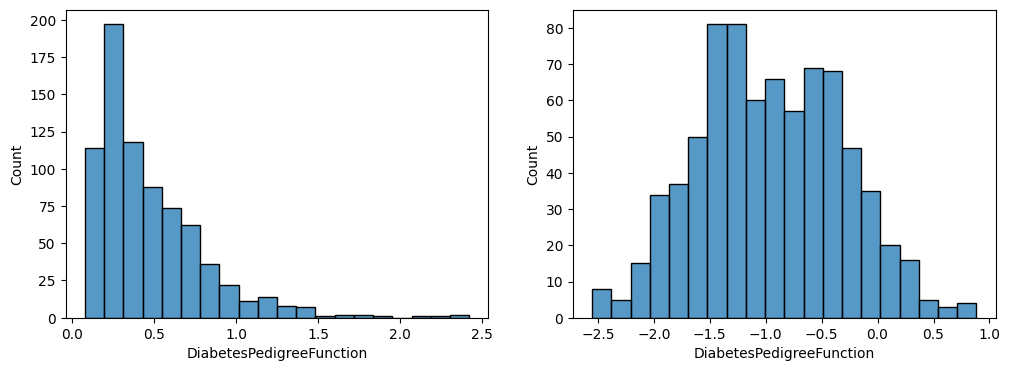

In [17]:

log_DiabetesPedigreeFunction = np.log(diabetes['DiabetesPedigreeFunction'])
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
histplot = sns.histplot(diabetes['DiabetesPedigreeFunction'], bins=20, ax=axes[0])
histplot2 = sns.histplot(log_DiabetesPedigreeFunction, bins=20, ax=axes[1])

#### Задания на самопроверку

In [2]:
import openpyxl

ModuleNotFoundError: No module named 'openpyxl'

In [3]:
new_data = pd.read_excel('data/Data_TSUM.xlsx')
display(new_data)

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.